Date: 2024-09-02, Trades Executed: 4, Daily P&L: -75.29999999999995
  - ('SIGNAL-1 SELL', Timestamp('2024-09-02 11:23:00'), 186.45)
  - ('SIGNAL-1 SELL', Timestamp('2024-09-02 11:35:00'), 208.85)
  - ('SIGNAL-1 SELL', Timestamp('2024-09-02 11:40:00'), 235.45)
  - ('SIGNAL-1 SELL', Timestamp('2024-09-02 13:00:00'), 185.15)
Date: 2024-09-03, Trades Executed: 1, Daily P&L: -17.299999999999997
  - ('SIGNAL-1 SELL', Timestamp('2024-09-03 09:48:00'), 105.2)
  - ('STOPLOSS', Timestamp('2024-09-03 10:01:00'), 122.5)
Date: 2024-09-04, Trades Executed: 2, Daily P&L: -138.15
  - ('SIGNAL-1 SELL', Timestamp('2024-09-04 10:46:00'), 148.9)
  - ('SIGNAL-1 SELL', Timestamp('2024-09-04 14:57:00'), 10.75)
Date: 2024-09-05, Trades Executed: 2, Daily P&L: -19.85
  - ('SIGNAL-1 SELL', Timestamp('2024-09-05 14:24:00'), 24.3)
  - ('SIGNAL-1 SELL', Timestamp('2024-09-05 14:50:00'), 7.0)
  - ('STOPLOSS', Timestamp('2024-09-05 14:51:00'), 9.55)
Date: 2024-09-06, Trades Executed: 1, Daily P&L: -74.34999999999997

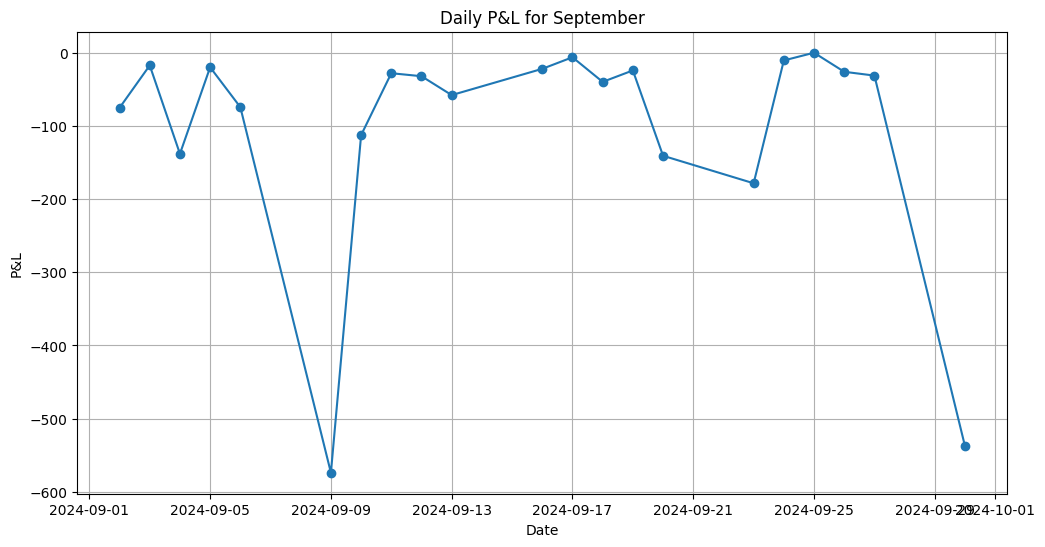

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

data_path = "ultimate_combined_data.csv"
data = pd.read_csv(data_path)
data['category'] = pd.to_datetime(data['category']).dt.date

def create_timestamps(date, count):
    start_time = datetime.combine(date, datetime.strptime("09:00", "%H:%M").time())
    return [start_time + timedelta(minutes=i) for i in range(count)]

timestamps = []
for day in data['category'].unique():
    day_data = data[data['category'] == day]
    timestamps.extend(create_timestamps(day, len(day_data)))

data['Timestamp'] = timestamps
data = data[data['Timestamp'].dt.time >= datetime.strptime("09:20", "%H:%M").time()]

daily_results = {}

for day, group in data.groupby('category'):
    low_point = float('inf')
    high_price = None
    last_executed_price = None
    trades = []
    num_trades = 0
    max_price = 0

    for _, row in group.iterrows():
        price = row['Straddle Price']
        time = row['Timestamp']

        if price < low_point:
            low_point = price
        if price > max_price:
            max_price = price
        if price >= 1.25 * low_point:
            high_price = group[(group['Timestamp'] > time) & 
                               (group['Timestamp'] <= time + timedelta(minutes=1))]['Straddle Price'].max()
        if high_price and price <= 0.95 * high_price:
            trades.append(('SIGNAL-1 SELL', time, price))
            last_executed_price = price
            num_trades += 1
            high_price = None
            if num_trades == 4:
                break
        if last_executed_price and price >= 1.15 * last_executed_price:
            trades.append(('STOPLOSS', time, price))
            break

    daily_pnl = sum([last_executed_price - trade[2] for trade in trades if last_executed_price])
    daily_results[day] = {
        'Number of Trades': num_trades,
        'Daily P&L': daily_pnl,
        'Trades Detail': trades
    }

for date, details in daily_results.items():
    print(f"Date: {date}, Trades Executed: {details['Number of Trades']}, Daily P&L: {details['Daily P&L']}")
    for trade in details['Trades Detail']:
        print(f"  - {trade}")

dates = list(daily_results.keys())
pnl_values = [result['Daily P&L'] for result in daily_results.values()]
plt.figure(figsize=(12, 6))
plt.plot(dates, pnl_values, marker='o', linestyle='-')
plt.title('Daily P&L for September')
plt.xlabel('Date')
plt.ylabel('P&L')
plt.grid(True)
plt.show()
